In [1]:
import numpy as np
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import TwoLocal
from IPython.display import display
import qtpu

/Users/nathanieltornow/qtpu/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
N = 6
circuit = TwoLocal(N, ["ry", "rz"], "rzz", entanglement="linear", reps=2).decompose()
circuit = circuit.assign_parameters(
    {param: np.random.rand() * np.pi / 2 for param in circuit.parameters}
)

circuit.measure_all()

# circuit.draw("mpl", fold=-1)
# circuit = QuantumCircuit(N)
# circuit.h(0)
# circuit.h(1)
# circuit.h(2)
# circuit.cx(range(N-1), range(1, N))

# circuit.measure_all()

100%|██████████| 10/10 [00:00<00:00, 61.49it/s]


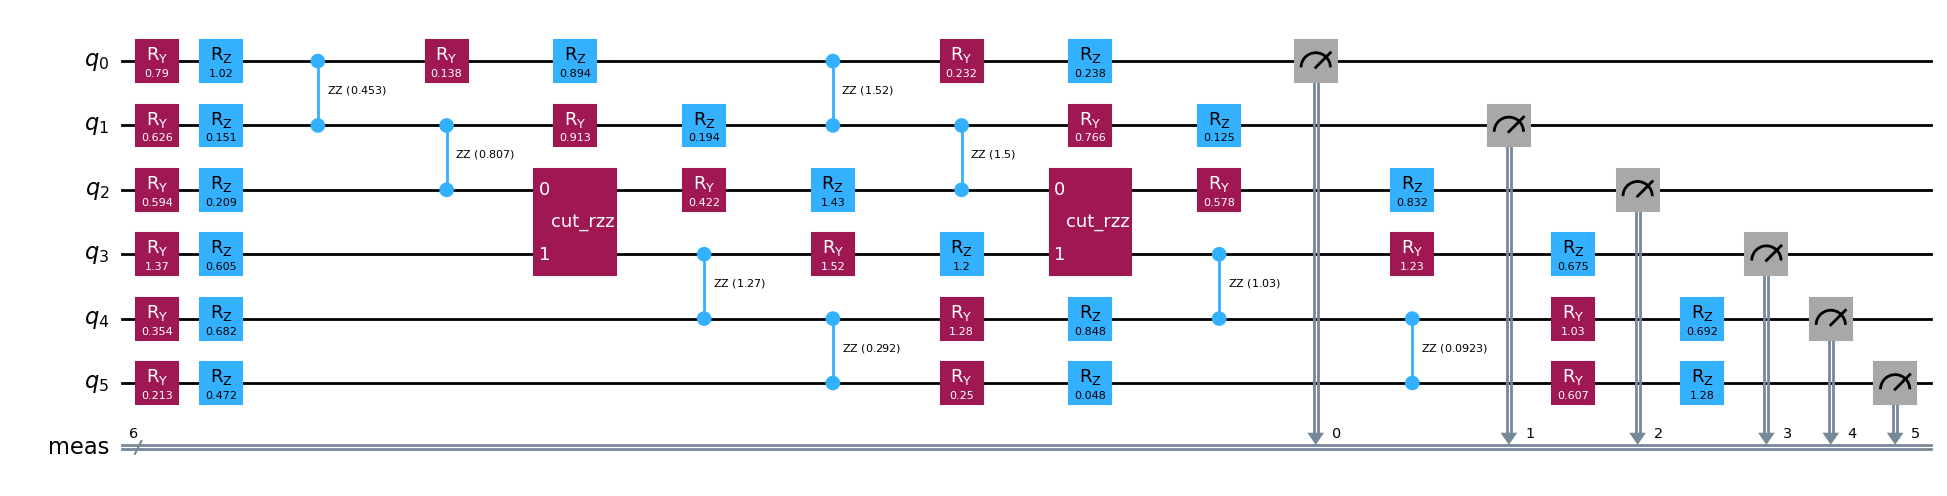

In [3]:
cut_circuit = qtpu.cut(
    circuit, num_qubits=N // 2, show_progress_bar=True, n_trials=10, max_overhead=160
)
cut_circuit.draw("mpl", fold=-1)

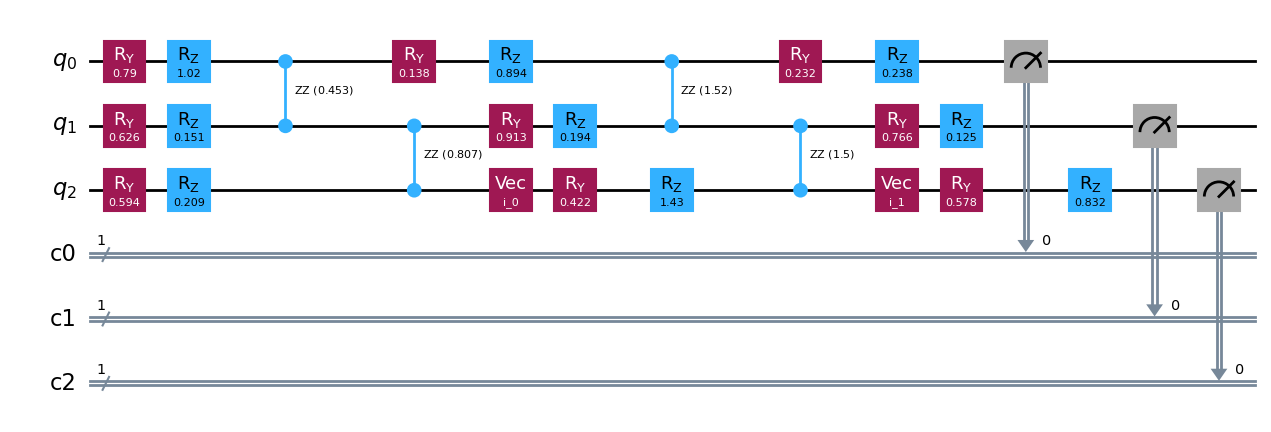

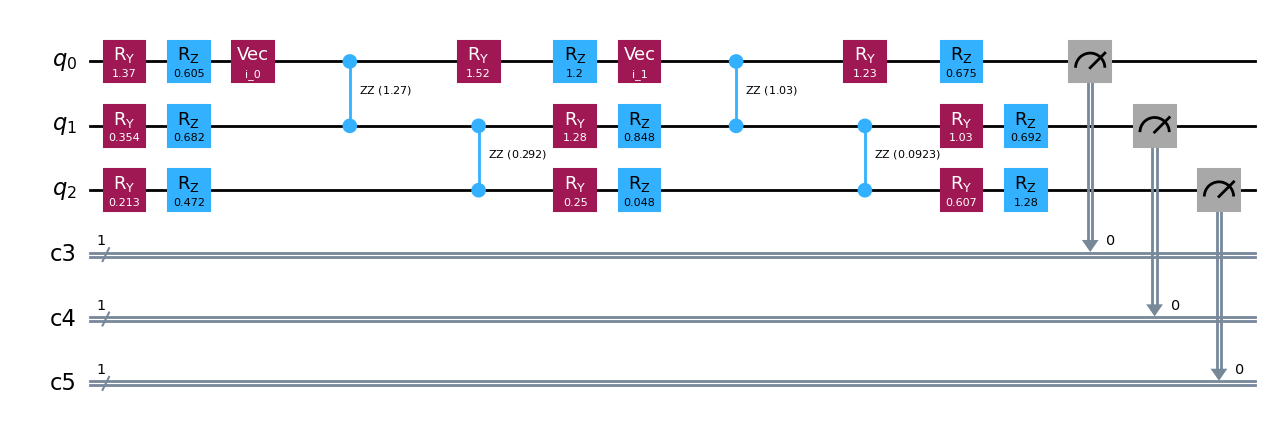

In [4]:
htn = qtpu.circuit_to_hybrid_tn(cut_circuit)
for c in htn.subcircuits:
    display(c.draw("mpl", fold=-1))


# print(f"Postprocessing Overhead: {htn.contraction_cost()}")
# print(f"Number of circuits: {htn.num_circuits()}")
# htn.draw()

In [5]:
from qtpu.evaluators.sim_sampler import SamplerEvaluator
from qtpu.evaluators.sim_estimator import SimExpvalEvaluator

evaluator = SamplerEvaluator()

from qtpu.contract import evaluate

tn = evaluate(htn, SamplerEvaluator())

import quimb.tensor as qtn




[[[[[[3.20189193e-01 4.69152919e-03]
     [1.45109227e-02 5.05769989e-02]]

    [[1.03685558e-02 3.92347906e-03]
     [3.58883387e-02 1.25207082e-02]]]


   [[[6.67337017e-02 1.04234566e-03]
     [4.96718540e-03 1.11970901e-02]]

    [[6.08268183e-04 2.80840439e-04]
     [3.13072234e-03 1.74462601e-03]]]]



  [[[[1.11231441e-01 3.23724034e-03]
     [4.55377335e-03 1.38351717e-02]]

    [[7.82242831e-04 5.06576794e-03]
     [3.67396672e-02 7.27892258e-03]]]


   [[[1.12777156e-02 1.29205922e-04]
     [2.66282649e-03 3.81408125e-03]]

    [[4.58492037e-03 2.13834015e-03]
     [1.07777946e-02 8.51801484e-04]]]]]




 [[[[[8.94351476e-02 1.27346787e-03]
     [4.05146263e-03 1.42555195e-02]]

    [[3.15833053e-03 1.08074786e-03]
     [9.80908098e-03 3.43728259e-03]]]


   [[[1.99416179e-02 3.11961424e-04]
     [1.39850114e-03 3.29051567e-03]]

    [[1.48728046e-04 6.65034669e-05]
     [8.66212308e-04 5.32738995e-04]]]]



  [[[[4.14328222e-02 1.15369588e-03]
     [1.77844593e-03 5.25332670

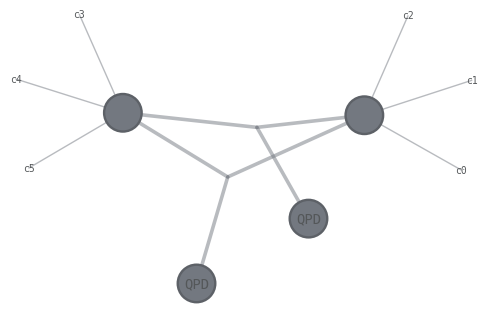

In [6]:
outers = sorted(tn.outer_inds(), reverse=True)

resful = tn.contract(output_inds=outers)
print(resful.data)
# # print(tn.contract(output_inds=[]))
tn.draw()

In [7]:
from qiskit_aer.primitives import SamplerV2

result = SamplerV2().run([circuit], shots=10000).result()[0].data.meas.get_counts()
print(result)

result_arr = np.array([result.get(bin(i)[2:].zfill(N), 0) for i in range(2**N)]) / 10000


print(np.linalg.norm(result_arr - resful.data.flatten()))

{'100111': 40, '001100': 12, '011110': 112, '001000': 732, '000000': 3266, '000001': 44, '100000': 910, '000101': 39, '100011': 151, '101011': 29, '010000': 1085, '010001': 23, '110000': 374, '110111': 22, '000010': 170, '101000': 208, '010111': 55, '011011': 40, '110110': 123, '000011': 522, '101001': 5, '011100': 54, '000100': 104, '000111': 129, '010110': 318, '000110': 340, '010101': 67, '011000': 135, '110010': 21, '001110': 36, '110101': 14, '110011': 54, '100110': 102, '101111': 6, '111000': 45, '100001': 10, '010011': 139, '100100': 33, '111110': 29, '111010': 7, '001011': 92, '010010': 37, '001111': 22, '001010': 40, '111100': 9, '011111': 13, '101110': 16, '011010': 29, '100010': 45, '111011': 11, '101010': 14, '111111': 4, '011101': 17, '110001': 9, '010100': 11, '001001': 9, '100101': 10, '110100': 2, '001101': 1, '111101': 3, '101100': 1}
0.013496877583637107


In [8]:
from qtpu.helpers import nearest_probability_distribution


def sample(tn: qtn.TensorNetwork, shots: int = 10) -> list[str]:
    outer_inds = sorted(tn.outer_inds())
    assert all(tn.ind_size(ind) == 2 for ind in outer_inds)

    outputs = []
    for _ in range(shots):
        output = ""
        tn_ = tn.copy()
        for ind in outer_inds:
            result = tn_.contract(all, output_inds=[ind]).data
            assert len(result.data) == 2

            result /= sum(result)

            result = nearest_probability_distribution(result)
            result = np.array([result.get(0, 0), result.get(1, 0)])

            try:
                sample = np.random.choice(2, p=result)
            except:
                print(result)
                raise

            arr = np.array([1, 0]) if sample == 0 else np.array([0, 1])

            tn_.add_tensor(qtn.Tensor(arr, inds=[ind]))

            output = str(sample) + output

        outputs.append(output)

    return outputs


res = sample(tn, 100000)
# print(res.count("1110"))
# # print(res.count("0000"))
from collections import Counter

cntr = Counter(res)
print(cntr)

Counter({'000000': 32446, '000010': 11237, '000001': 9090, '000100': 6763, '110000': 5099, '000011': 4289, '011010': 3706, '011000': 3579, '000101': 2024, '010000': 1483, '110001': 1432, '110010': 1393, '011011': 1254, '111000': 1238, '000110': 1161, '011110': 1129, '110100': 1091, '001000': 1067, '011001': 951, '111010': 726, '101010': 556, '010100': 535, '110011': 515, '100000': 478, '010010': 472, '001110': 440, '010001': 430, '011111': 399, '101000': 397, '110110': 392, '100010': 332, '110101': 328, '111001': 321, '011100': 304, '001001': 295, '010110': 260, '111011': 248, '101110': 203, '101011': 171, '010011': 156, '111100': 152, '010101': 147, '001111': 123, '100001': 118, '100100': 112, '101001': 109, '100011': 105, '000111': 95, '111110': 80, '011101': 72, '001010': 71, '101111': 69, '110111': 66, '010111': 64, '001100': 57, '111101': 47, '111111': 27, '101100': 23, '100101': 21, '001011': 17, '100110': 16, '001101': 13, '101101': 6})


In [9]:
from qiskit_aer import AerSimulator


# print(other_result)

counts = AerSimulator().run(circuit, shots=100000).result().get_counts()
#
print(counts)


from qiskit.quantum_info import hellinger_fidelity

print(hellinger_fidelity(counts, cntr))

{'001101': 19, '110100': 21, '111101': 53, '111111': 40, '111001': 1, '100001': 128, '010100': 111, '011001': 5, '110111': 254, '001111': 191, '110101': 148, '011111': 110, '101100': 19, '100111': 361, '100100': 329, '100010': 429, '101010': 166, '000100': 1076, '110001': 83, '000000': 31868, '011101': 210, '000101': 352, '010101': 439, '010000': 11185, '100110': 1002, '101101': 4, '110011': 449, '110010': 174, '101011': 384, '010111': 766, '010110': 3584, '010001': 258, '011011': 362, '001001': 87, '001011': 1152, '101110': 123, '111000': 539, '000010': 1494, '010011': 1274, '001110': 375, '010010': 464, '011000': 1446, '111100': 123, '001000': 7016, '111010': 75, '100011': 1449, '000110': 3634, '011110': 1127, '000111': 1230, '111110': 372, '100000': 9103, '110000': 3974, '101111': 64, '011100': 471, '110110': 1248, '001100': 89, '101000': 2058, '001010': 487, '011010': 258, '100101': 102, '000001': 443, '101001': 25, '000011': 4987, '111011': 130}
0.6287924100135992


In [10]:
# get the result <ZZ..Z>

res = qtpu.contract(htn, evaluator)
print(f"qTPU result: {res}")

qTPU result: 1.0012436225224475


In [11]:
from qiskit_aer.primitives import EstimatorV2

est = EstimatorV2()

perf_res = (
    est.run(
        [(circuit.remove_final_measurements(inplace=False), "Z" * circuit.num_qubits)]
    )
    .result()[0]
    .data.evs
)
print(f"Qiskit result: {perf_res}")
# print(f"Error: {abs(res - perf_res)}")

Qiskit result: 0.12690454999150047


In [12]:
from mqt.bench import CompilerSettings, QiskitSettings, TKETSettings, get_benchmark

from qtpu.helpers import remove_barriers

qc_algorithmic_level = get_benchmark(
    benchmark_name="ae",
    level="indep",
    circuit_size=12,
    kwargs={"entanglement": "linear"},
)
qc_algorithmic_level.draw(output="mpl", fold=-1)

ModuleNotFoundError: No module named 'mqt'

In [ ]:
from qtpu.circuit import cuts_to_moves, subcircuits
from mqt.bench.utils import calc_supermarq_features


def super_features(circuit):
    circuit = cuts_to_moves(circuit)
    subcircs = subcircuits(circuit)
    return calc_supermarq_features(subcircs[0])

In [ ]:
features = calc_supermarq_features(qc_algorithmic_level)
print(features)

In [ ]:
from qtpu.compiler.dep_graph import (
    circuit_to_dep_graph,
    reduce_deps_greedy,
    uncycle,
    remove_critical_gates,
)

cut_circuit = remove_critical_gates(remove_barriers(qc_algorithmic_level), 3)
print(super_features(cut_circuit))
# cut_circuit.draw(output="mpl")
# import networkx as nx
# graph = circuit_to_dep_graph(remove_barriers(qc_algorithmic_level))
# print(nx.is_directed_acyclic_graph(graph))
# uncycle(graph)
# nx.draw(graph, with_labels=True)